In [39]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

%matplotlib notebook
import numpy as np

from delfi.simulator.Gauss import Gauss

In [49]:
n_params = 1
n_rounds = 20
n_samples_per_round = 1
seed = 42
m = Gauss(dim=n_params, seed=seed)

p = dd.Gaussian(m=[0], S=[[25]], seed=seed)
s = ds.Identity()
g = dg.Default(model=m, prior=p, summary=s)

_, x_obs = g.gen(1, verbose=False)

# generate and plot
params, stats = g.gen(250, verbose=False)
plt.plot(stats, params, 'b.')
plt.xlabel('x')
plt.ylabel('theta')

print(x_obs)

[[ 2.87911058]]


In [50]:
# set up inference
#res = infer.CDELFI(g, obs=obs, n_components=2)

res = infer.Basic(g, n_hiddens=[10], seed=seed, svi=True, verbose=False)

posts = []

for i in tqdm(range(n_rounds)):
    # run with N samples
    log, trn_data = res.run(n_samples_per_round)
    post = res.predict(x_obs)
    assert post.ndim == 1, "Number of components needs to be "
    gpost = post.xs[0]
    posts.append(gpost)

[-0.24115168]


<IPython.core.display.Javascript object>


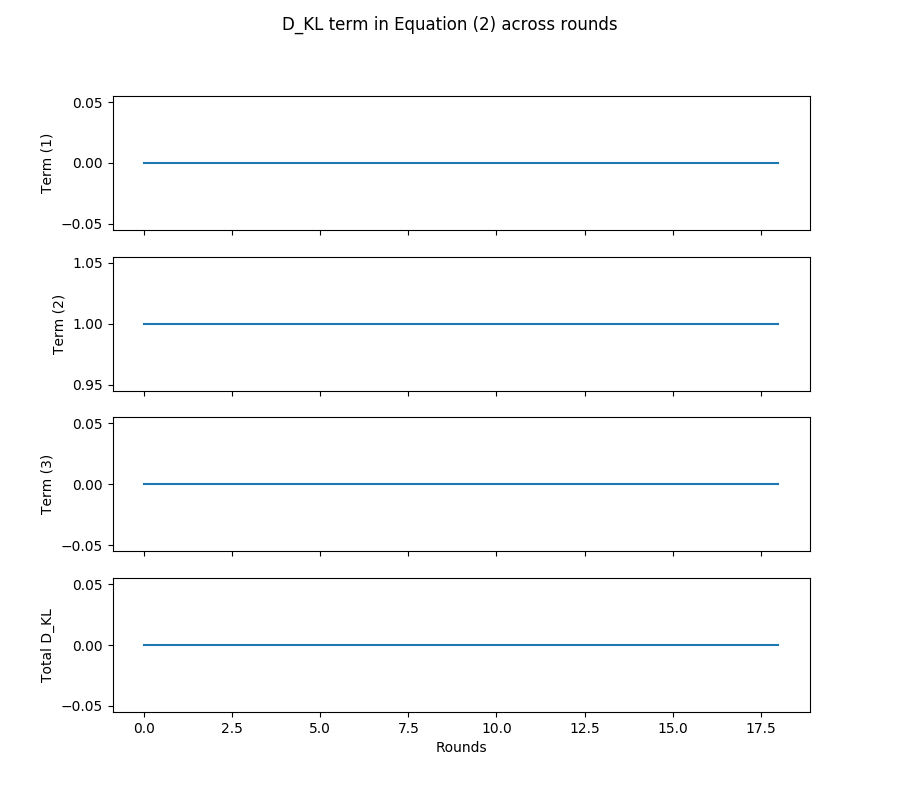

In [51]:
# The DKL between two Gaussians is given by: ...

logdetPs = [ p.logdetP for p in posts ]
dkl1s = np.diff(logdetPs)

dkl2s = [ np.trace(posts[i+1].P * posts[i].S) for i in range(len(posts) - 1) ]

means = [ p.m for p in posts ]
meandiffs = np.diff(means, axis=0)

dkl3s = [ md.T.dot(p.P.dot(md)) for p, md in zip(posts[:-1], meandiffs) ]

dkls = 0.5 * (-dkl1s - n_params + dkl2s + dkl3s)

xlist = range(0, len(dkls))

fig, (ax1, ax2, ax3, axtot) = plt.subplots(4, sharex=True, figsize=(9,8))

fig.suptitle("D_KL term in Equation (2) across rounds")

ax1.set_ylabel("Term (1)")
ax1.plot(xlist, dkl1s)

ax2.set_ylabel("Term (2)")
ax2.plot(xlist, dkl2s)

ax3.set_ylabel("Term (3)")
ax3.plot(xlist, dkl3s)

axtot.set_ylabel("Total D_KL")
axtot.plot(xlist, dkls)
axtot.set_xlabel("Rounds")

plt.show()